# BM25 Document Store Demo

This notebook demonstrates the `BM25DocumentStore` class for keyword-based retrieval of financial documents.

In [27]:
from entropy.contexts.retrieval import BM25DocumentStore, YFinanceFetcher
from entropy.utils.Seans_helpers import print_obj_map

## Setup

Fetch from yfinance for a few example stocks.

In [ ]:
# Fetch real news from yfinance
tickers = ["AAPL", "TSLA", "MSFT", "NVDA"]
fetcher = YFinanceFetcher()
texts, metadata = fetcher.fetch_news(tickers)

print(f"Fetched {len(texts)} articles across {len(tickers)} tickers")

2025-10-05 16:33:47.673 | DEBUG    | entropy.contexts.retrieval.yfinance_fetcher:__init__:17 - Initialized YFinanceFetcher
2025-10-05 16:33:47.675 | INFO     | entropy.contexts.retrieval.yfinance_fetcher:fetch_news:40 - Fetching news for AAPL
2025-10-05 16:33:47.880 | INFO     | entropy.contexts.retrieval.yfinance_fetcher:fetch_news:69 - Fetched 10 articles for AAPL
2025-10-05 16:33:47.881 | INFO     | entropy.contexts.retrieval.yfinance_fetcher:fetch_news:40 - Fetching news for TSLA
2025-10-05 16:33:48.125 | INFO     | entropy.contexts.retrieval.yfinance_fetcher:fetch_news:69 - Fetched 10 articles for TSLA
2025-10-05 16:33:48.126 | INFO     | entropy.contexts.retrieval.yfinance_fetcher:fetch_news:40 - Fetching news for MSFT
2025-10-05 16:33:48.295 | INFO     | entropy.contexts.retrieval.yfinance_fetcher:fetch_news:69 - Fetched 10 articles for MSFT
2025-10-05 16:33:48.296 | INFO     | entropy.contexts.retrieval.yfinance_fetcher:fetch_news:40 - Fetching news for NVDA
2025-10-05 16:33:48

Fetched 40 articles across 4 tickers


## Create and Populate Store

Initialize the BM25 document store and index the fetched articles.

In [3]:
store = BM25DocumentStore()
store.add_documents(texts, metadata)

stats = store.get_stats()
print(f"Documents: {stats['num_documents']}")
print(f"Tickers: {', '.join(stats['tickers'])}")

2025-10-05 16:33:54.945 | DEBUG    | entropy.contexts.retrieval.bm25_retrieval:__init__:19 - Initialized empty BM25DocumentStore
2025-10-05 16:33:54.946 | INFO     | entropy.contexts.retrieval.bm25_retrieval:add_documents:28 - Adding 40 documents to BM25 store
2025-10-05 16:33:54.947 | DEBUG    | entropy.contexts.retrieval.bm25_retrieval:add_documents:36 - Building BM25 index
2025-10-05 16:33:54.949 | INFO     | entropy.contexts.retrieval.bm25_retrieval:add_documents:38 - BM25 store now contains 40 documents


Documents: 40
Tickers: AAPL, MSFT, NVDA, TSLA


Hierarchical structure of `BM25DocumentStore` object 

In [48]:
print_obj_map(store, include_dicts=False, header="store", max_depth=3);

print(store.bm25_index.idf)

store: <class 'entropy.contexts.retrieval.bm25_retrieval.BM25DocumentStore'>
	store.bm25_index: <class 'rank_bm25.BM25Okapi'>
		store.bm25_index.k1: <class 'float'>
		store.bm25_index.b: <class 'float'>
		store.bm25_index.epsilon: <class 'float'>
		store.bm25_index.corpus_size: <class 'int'>
		store.bm25_index.avgdl: <class 'float'>
		store.bm25_index.doc_freqs: <class 'list'> 40
		store.bm25_index.idf: <class 'dict'> 750
		store.bm25_index.doc_len: <class 'list'> 40
		store.bm25_index.tokenizer: <class 'NoneType'>
		store.bm25_index.average_idf: <class 'float'>
	store.documents: <class 'list'> 40
	store.tokenized_corpus: <class 'list'> 40
	store.verbose: <class 'bool'>
{'wall': 1.341173925839421, 'street,': 2.371577964480997, 'crypto': 2.371577964480997, 'industry': 1.8647846042429448, 'say': 2.371577964480997, 'tokenization': 2.371577964480997, 'will': 1.341173925839421, 'reshape': 2.371577964480997, 'global': 2.371577964480997, 'markets:': 2.371577964480997, "'it’s": 2.3715779644809

## Search with BM25

Search for documents using BM25 ranking, which excels at exact term matching (ticker symbols, keywords).

In [38]:
def print_search_result_summary(results, query=None):

    if query is not None:
        print(f"\nQuery: '{query}'\n")

    for i, result in enumerate(results):
        doc = result["document"]
        score = result["score"]
        print(f"{i+1}. [{doc['metadata']['ticker']}] {doc['metadata']['title']}")
        print(f"   Score: {score:.2f}")

In [42]:
query = "AI chips revenue"

results = store.search(query, k=5)

print_search_result_summary(results, query=query)

2025-10-05 16:56:15.525 | DEBUG    | entropy.contexts.retrieval.bm25_retrieval:search:47 - Searching: 'AI chips revenue' (k=5, filter=None)
2025-10-05 16:56:15.529 | INFO     | entropy.contexts.retrieval.bm25_retrieval:search:70 - Found 5 results (top score: 4.04)



Query: 'AI chips revenue'

1. [MSFT] AI Stocks Face 'Show Me' Test. OpenAI Holds Big Event As Valuation Soars
   Score: 4.04
2. [NVDA] AI Stocks Face 'Show Me' Test. OpenAI Holds Big Event As Valuation Soars
   Score: 4.04
3. [AAPL] Foxconn third-quarter revenue hits record, misses market forecast
   Score: 2.93
4. [NVDA] Why Micron Stock Exploded 40% Higher in September
   Score: 1.29
5. [NVDA] 4 Best Artificial Intelligence (AI) Stocks to Buy in October
   Score: 1.27


Uncomment cell below to see hierarchical data structure example

In [31]:
# print_obj_map(results[0], header="result", mode="value");

## Filter by Ticker

Search within a specific ticker symbol to narrow results.

In [41]:
results = store.search(query, k=5, filter_ticker="TSLA")

print_search_result_summary(results, query=query)

2025-10-05 16:56:02.276 | DEBUG    | entropy.contexts.retrieval.bm25_retrieval:search:47 - Searching: 'AI chips revenue' (k=5, filter=TSLA)
2025-10-05 16:56:02.277 | DEBUG    | entropy.contexts.retrieval.bm25_retrieval:search:56 - Filtering to ticker: TSLA
2025-10-05 16:56:02.278 | INFO     | entropy.contexts.retrieval.bm25_retrieval:search:70 - Found 5 results (top score: 0.92)



Query: 'AI chips revenue'

1. [TSLA] Government Shutdown, OpenAI Conference and Other Can't Miss Items this Week
   Score: 0.92
2. [TSLA] Wall Street, crypto industry say tokenization will reshape global markets: 'It’s going to eat the entire financial system'
   Score: 0.00
3. [TSLA] Dow Jones Futures Loom, Palantir Looks To Rebound; More Big Tesla News Due
   Score: 0.00
4. [TSLA] Tesla FSD v14 Release Coming Monday, Elon Musk Says
   Score: 0.00
5. [TSLA] Jim Cramer Reveals Major Potential Catalyst For Ford (F)
   Score: 0.00


## Inspect Tokenization

In [ ]:
print("Example document tokenized:")

max_line_len = 120
current_line = []
current_len = 0

for token in store.tokenized_corpus[0]:
    token_str = f"<{token}>"
    token_len = len(token_str) + 1  # +1 for the space
    
    if current_len + token_len > max_line_len and current_line:
        print(" ".join(current_line))
        current_line = [token_str]
        current_len = token_len
    else:
        current_line.append(token_str)
        current_len += token_len

# Print remaining tokens
if current_line:
    print(" ".join(current_line))

print(f"\nLength: {len(store.tokenized_corpus[0])} tokens")


Example document tokenized:
<wall> <street,> <crypto> <industry> <say> <tokenization> <will> <reshape> <global> <markets:> <'it’s> <going> <to>
<eat> <the> <entire> <financial> <system'> <the> <crypto> <industry,> <along> <with> <wall> <street> <heavyweights,>
<wants> <to> <bring> <tokenized> <stocks,> <or> <digital> <versions> <of> <traditional> <shares> <that> <are>
<recorded> <on> <a> <blockchain's> <digital> <ledger,> <into> <the> <mainstream.>

Length: 48 tokens


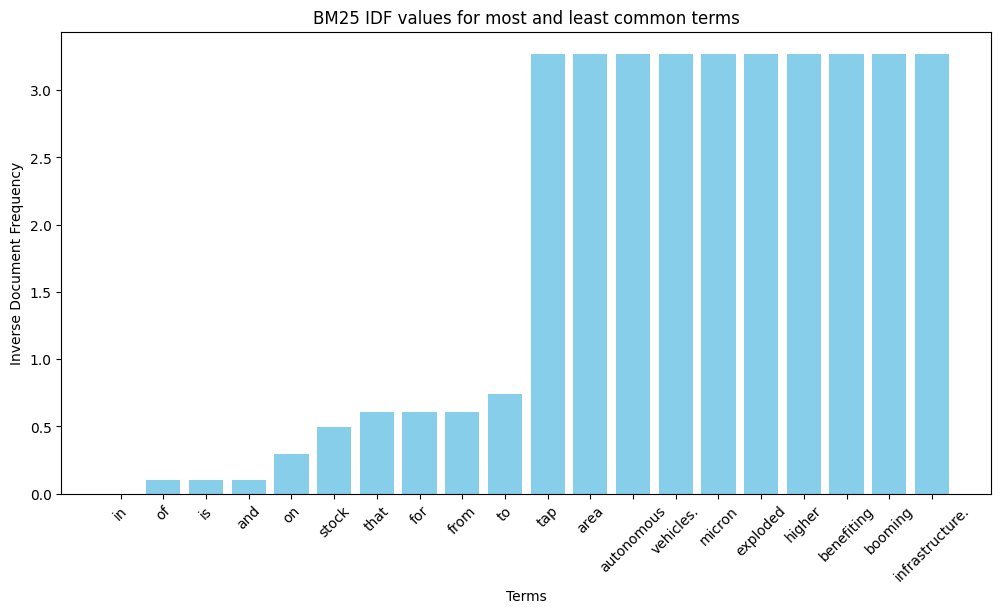

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
idf_dict = store.bm25_index.idf

labels = sorted(idf_dict, key=idf_dict.get)

n_most_extreme = 10
labels = labels[:n_most_extreme] + labels[-n_most_extreme:]
values = [idf_dict[k] for k in labels]

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Terms')
plt.ylabel('Inverse Document Frequency')
plt.title('BM25 IDF values for most and least common terms')
plt.xticks(rotation=45);
